In [22]:
from os import close
from binance.client import Client
import json
import pandas as pd
import ta
from ta.volatility import BollingerBands
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
json_path = "/home/pi/Desktop/python/crypto/config.json"

with open(json_path, "r") as f:
    config = json.load(f)

client = Client(config["api_key"], config["secret_key"])

In [44]:
def getMinData (symbol, interval, lookback):
    #returns OHLCV
    frame = pd.DataFrame(client.get_historical_klines(symbol = symbol, interval = interval, start_str= lookback))
    frame = frame.iloc[:, :6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    #frame = frame.set_index('Time') 
    #frame.index = pd.to_datetime(frame.index, unit = 'ms')
    frame['Time'] = pd.to_datetime(frame['Time'], unit = 'ms')
    frame[['Open', 'High', 'Low', 'Close', 'Volume']] = frame[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
    return frame

def applyTechnicals(df):
    df['RSI'] = ta.momentum.rsi(close = df["Close"], window = 14)
    df["MA200"] = df["Close"].rolling(200).mean()
    indicator_bb = BollingerBands(close = df["Close"], window = 20, window_dev = 2)
    df["bb_bbm"] = indicator_bb.bollinger_mavg()
    df["bb_high_band"] = indicator_bb.bollinger_hband()
    df["bb_low_band"] = indicator_bb.bollinger_lband()

    #df['%K'] = ta.momentum.stoch(df["High"],df["Low"], df["Close"], window = 14, smooth_window = 3)

In [57]:

#strateg: rsi; bb
def testing_strategy(df, strategy):

    buy = True
    lowerB = 30
    higherB = 70
    main_invest = 100
    invest = main_invest
    eth = 0
    log = []

    for i in range(13, len(df)):

        trading_day = df.iloc[i]
        close_date = trading_day["Time"]
        close_price = trading_day["Close"]
        
        
        if strategy == "rsi":
            rsi = trading_day["RSI"]

            if (buy and rsi <= lowerB):
                trx = {}
                buy = False
                eth = invest / close_price
                buyPrice = close_price
                trx["Type"] = "Buy"
                trx["Date"] = close_date
                trx["Close"] = close_price
                log.append(trx)

            #looking for selling opportunity
            elif (buy == False and rsi >= higherB and buyPrice < close_price):
                buy = True
                invest = close_price * eth
                trx = {}
                trx["Type"] = "Sell"
                trx["Date"] = close_date
                trx["Close"] = close_price
                trx["Total Profit"] = invest - main_invest
                log.append(trx)

        elif strategy == "bb":
            bb_high_band = trading_day["bb_high_band"]
            bb_low_band = trading_day["bb_low_band"]

            if (buy and close_price <= bb_low_band):
                trx = {}
                buy = False
                eth = invest / close_price
                buyPrice = close_price
                trx["Type"] = "Buy"
                trx["Date"] = close_date
                trx["Close"] = close_price
                log.append(trx)

            #looking for selling opportunity
            elif (buy == False and close_price >= bb_high_band and buyPrice < close_price):
                buy = True
                invest = close_price * eth
                trx = {}
                trx["Type"] = "Sell"
                trx["Date"] = close_date
                trx["Close"] = close_price
                trx["Total Profit"] = invest - main_invest
                log.append(trx)

        elif strategy == "rsibb":
            bb_high_band = trading_day["bb_high_band"]
            bb_low_band = trading_day["bb_low_band"]
            rsi = trading_day["RSI"]

            if (buy and close_price <= bb_low_band and rsi <= lowerB):
                trx = {}
                buy = False
                eth = invest / close_price
                buyPrice = close_price
                trx["Type"] = "Buy"
                trx["Date"] = close_date
                trx["Close"] = close_price
                log.append(trx)

            #looking for selling opportunity
            elif (buy == False and close_price >= bb_high_band and rsi >= higherB and buyPrice < close_price):
                buy = True
                invest = close_price * eth
                trx = {}
                trx["Type"] = "Sell"
                trx["Date"] = close_date
                trx["Close"] = close_price
                trx["Total Profit"] = invest - main_invest
                log.append(trx)



    return pd.DataFrame(log)

In [59]:
df = getMinData(symbol = "ETHUSDT", interval = "15m", lookback = "6 months ago UTC")
applyTechnicals(df)
df.tail(10)

In [74]:
strategies = ["rsi", "bb", "rsibb"]
profits = []

for strategy in strategies:
    d_strategy = {}
    log_df = testing_strategy(df, strategy)
    d_strategy["strategy"] = strategy
    d_strategy["Max Profit"] = log_df["Total Profit"].max()

    profits.append(d_strategy)

profits


[{'strategy': 'rsi', 'Max Profit': 46.821373020644444},
 {'strategy': 'bb', 'Max Profit': 34.919886789631136},
 {'strategy': 'rsibb', 'Max Profit': 24.330044268192424}]

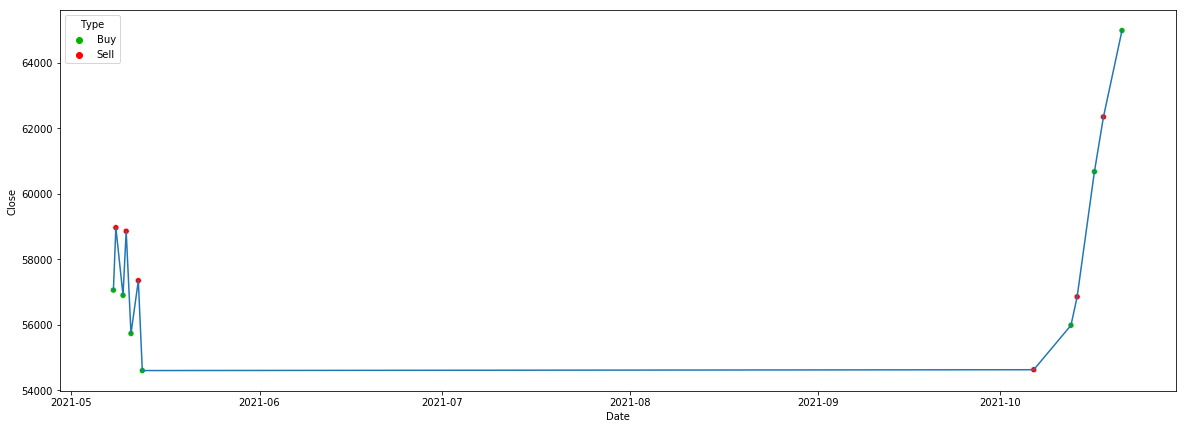

In [52]:
plt.figure(figsize=(20, 7))
sns.lineplot(data = log_df, x = "Date", y = "Close")
sns.scatterplot(data = log_df, x = "Date", y = "Close", hue = "Type", palette=dict(Buy = "#00b300", Sell = "#ff0000"))
